## LightGBM
- XGBoost와 함께 부스팅 계열 가장 각광받는 알고리즘
- XGBoost는 GridSearchCV로 하이퍼 파라미터 튜닝을 하다보면 시간이 너무 오래 걸려서 많은 파라미터를 튜닝하기에 어려움
### 장점
- XGBoost보다 학습에 걸리는 시간이 훨씬 적고 메모리 사용량도 상대적으로 적다는 점
- XGBoost의 예측 성능과 별다른 차이가 없고, 기능상의 다양성은 약간 더 많음
### 단점
- 적은 dataset에 적용할 경우 과적합이 발생하기 쉬움
- 적은 dataset이란 일반적으로 10,000건 이하의 dataset(LightGBM 공식 문서)
### 트리 분할 방법
- 리프 중심 분할(Leaf Wise) 방식
- 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할
- 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성
- 예측 오류 손실을 최소화 할 수 있다는 것이 LightGBM의 구현 사상
- 대용량 데이터에 대한 뛰어난 예측 성능과 병렬 컴퓨팅 기능을 제공하며 최근에는 GPU까지 지원


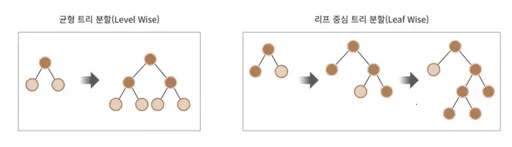

- 기존의 대부분 트리 기반 알고리즘 균형 트리 분할(Level Wise) 방식
- 대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화
- 이렇게 균형 잡힌 트리는 오버피팅에 보다 더 강한 구조


In [1]:
!pip install lightgbm

In [2]:
import lightgbm

print(lightgbm.__version__)


3.3.2


### LightGBM 하이퍼 파라미터
- XGBoost와 많은 부분이 유사
- 트리가 깊어지므로 트리 특성에 맞는 하이퍼 파라미터 설정이 필요
#### 주요 파라미터
- num_iterations [default=100]: 반복 수행하려는 트리의 개수를 지정
- learning_rate [default=0.1]: 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
- max_depth [default=-1]: 트리 기반 알고리즘의 max_depth와 같다. 0보다 작은 값을 지정하면 깊이에 제한이 없다
- min_data_in_leaf [default=20]: 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며, 과적합을 제어하기 위한 파라미터
- num_leaves [default=31]: 하나의 트리가 가질 수 있는 최대 리프 개수
- boosting [default=gbdt]: 부스팅의 트리를 생성하는 알고리즘
- gbdt : 일반적인 그래디언트 부스팅 결정 트리
- rf : 랜덤 포레스트
#### Learning Task 파라미터
- objective: 최솟값을 가져야 할 손실함수를 정의
- Xgboost의 objective 파라미터와 동일
#### 하이퍼 파라미터 튜닝 방안
- num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안
- num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수, 높이면 정확도 높아지지만 트리 깊어지고, 복잡도 커져서 과적합 영향도 커짐
- min_data_in_leaf(사이킷런:min_child_samples) 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지
- max_depth는 명시적으로 깊이의 크기를 제한


### LightGBM 적용 – 위스콘신 Breast Cancer Prediction

In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
# LGBMClassifier : 사이킷런 용 래퍼
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]


[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

C:\Users\NOTEBOOK\.conda\envs\py38\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\NOTEBOOK\.conda\envs\py38\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


조기 중단으로 145번 반복까지만 수행하고 학습이 종료

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [6]:
get_clf_eval(y_test, preds, pred_proba)


오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,    F1: 0.9682, AUC:0.9905


- 정확도가 약 94.74%
- XGBoost의 경우보다 작지만 학습/테스트 dataset 크가기 작아 비교가 큰 의미가 없음


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

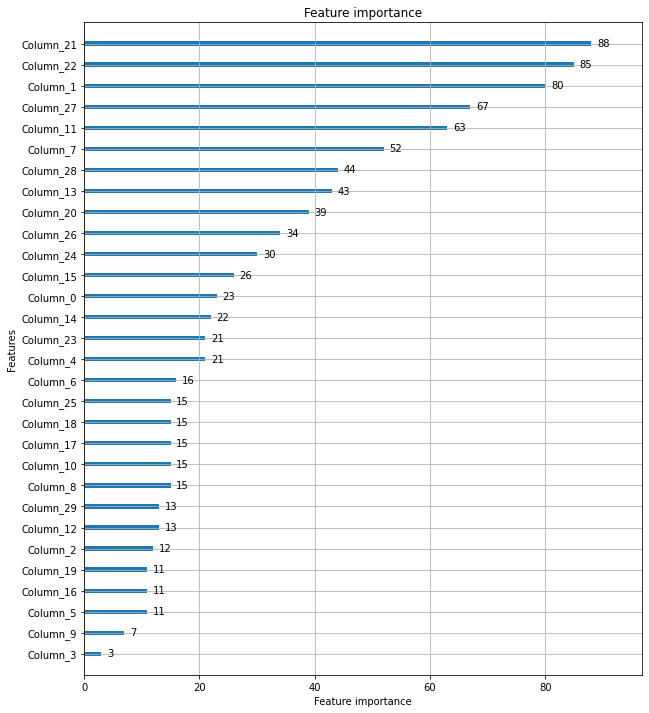

In [7]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)


lightGBM에 내장된 plotimportance()도 넘파이 feature 데이터로 학습할 경우 feature 명을 알 수 없기에 Column 뒤에 feature 순서대로 숫자를 붙여서 X축에 나열